In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pickle
from math import floor

In [2]:
# open required datasets
y_test = pd.read_csv('y_test.csv')
x_data_name = "x_test"
x_data_extension = ".csv"
file = open("Selection Methods","rb")
sel_methods = np.load(file)
model_path = "CrimeGUI/Models/"

In [3]:
# lists used for evaluation code
def setup_lists():
    algorithms = ['multi_layer_perceptron',
                  'decision_tree',
                  'elastic_net',
                  'lasso',
                  'linear_regression',
                  'random_forest',
                  'ridge_regression',
                  'svm']
    algorithm_display_names = ['Multi\nLayer\nPerceptron',
                               'Decision\nTree',
                               'Elastic Net',
                               'Lasso',
                               'Linear\nRegression',
                               'Random\nForest',
                               'Ridge\nRegression',
                               'SVM']
    feature_select_display_names = ['F Regression',
                               'Chi2',
                               'Adaboost',
                               'Equal crime\nand business',
                               'All Business']
    highest_is_best = {"r2":True,
                  "mse":False,
                  "mae":False}
    score_metrics = ["r2","mse","mae"]
    return algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics

In [4]:
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()

In [5]:
# get mse, mae and r2 scores for algorithm
def get_algorithm_results(algorithm):
    mse_scores = []
    mae_scores = []
    r2_scores = []
    for sel_method in sel_methods:
        try:
            x_test = pd.read_csv(x_data_name + sel_method + x_data_extension)
            file_path = model_path + algorithm + sel_method
            with open(file_path, 'rb') as f:
                model = pickle.load(f)
                y_predict = model.predict(x_test)
                mse = mean_squared_error(y_test,y_predict)
                mae = mean_absolute_error(y_test,y_predict)
                r2 = r2_score(y_test,y_predict)
                mse_scores.append(mse)
                mae_scores.append(mae)
                r2_scores.append(r2)
        except: 
            print("something went wrong for", algorithm + sel_method)
    return mse_scores, mae_scores, r2_scores

In [6]:
results_by_algorithm = {}
all_mse_results = []
all_mae_results = []
all_r2_results = []
for algorithm in algorithms:
    mse_scores, mae_scores, r2_scores = get_algorithm_results(algorithm)
    results_by_algorithm[algorithm] = {'mse':mse_scores,'mae':mae_scores,'r2':r2_scores}
    all_mse_results = all_mse_results + mse_scores
    all_mae_results = all_mae_results + mae_scores
    all_r2_results = all_r2_results + r2_scores
all_results = {'mse':all_mse_results,'mae':all_mae_results,'r2':all_r2_results}

In [7]:
# calculate best score for each algorithm
def best_score_per_algorithm(score_metric):
    best_scores = []
    for algorithm in algorithms:
        scores = results_by_algorithm[algorithm][score_metric]
        if highest_is_best[score_metric]:
            best_scores.append(max(scores))
        else:
            best_scores.append(min(scores))
    y_select = np.arange(len(best_scores))
    plt.figure(figsize = (15,15))
    ticks = plt.xticks(y_select,algorithm_display_names)
    title = plt.title("Best " + score_metric + " scores per algorithm")
    x_label = plt.xlabel("Algorithm")
    y_label = plt.ylabel(score_metric + " score")
    high_score = max(best_scores)
    low_score = min(best_scores)
    min_y = low_score - 0.5 * (high_score - low_score)
    max_y = high_score + 0.5 * (high_score - low_score)
    plt.ylim(bottom = min_y, top = max_y)
    bar = plt.bar(y_select, best_scores)
    return bar, ticks, title, x_label, y_label

In [8]:
# get plot labels
def get_labels():
    labels = []
    for algorithm in algorithms:
        for sel_method in sel_methods:
            labels.append(algorithm_display_names[algorithms.index(algorithm)] + "\nusing\n" + 
                          feature_select_display_names[np.nonzero(sel_methods == sel_method)[0][0]] + "\ndataset")
    return labels

In [9]:
# validate x, ensuring a positive number no higher than the number of results
def validate_x(num_scores,x):
    soft_cap = 15
    if num_scores < 0:
        return 0
    if x > num_scores or x < 1:
        if num_scores > soft_cap:
            return soft_cap
        else:
            return num_scores
    return x

In [10]:
# generate chart of the best x results of a given score metric (r2, mse, mae)
def best_x_scores(score_metric,x):
    all_labels = get_labels()
    x_labels = []
    best_scores = []
    scores = all_results[score_metric]
    num_scores = len(scores)
    x = validate_x(num_scores,x)
    num_sel_methods = len(sel_methods)
    i = 0
    while i < x:
        if highest_is_best[score_metric]:
            index = np.argmax(scores)
        else:
            index = np.argmin(scores)
        x_labels.append(all_labels[index])
        best_scores.append(scores[index])
        all_labels = np.delete(all_labels,index)
        scores = np.delete(scores,index)
        i+=1
    y_select = np.arange(len(best_scores))
    plt.figure(figsize = (15,15))
    ticks = plt.xticks(y_select,x_labels)
    title = plt.title("Top " + str(x) + " " + score_metric + " scores")
    x_label = plt.xlabel("Algorithm")
    y_label = plt.ylabel(score_metric + " score")
    high_score = max(best_scores)
    low_score = min(best_scores)
    min_y = low_score - 0.5 * (high_score - low_score)
    max_y = high_score + 0.5 * (high_score - low_score)
    plt.ylim(bottom = min_y, top = max_y)
    bar = plt.bar(y_select, best_scores)
    return bar, ticks, title, x_label, y_label

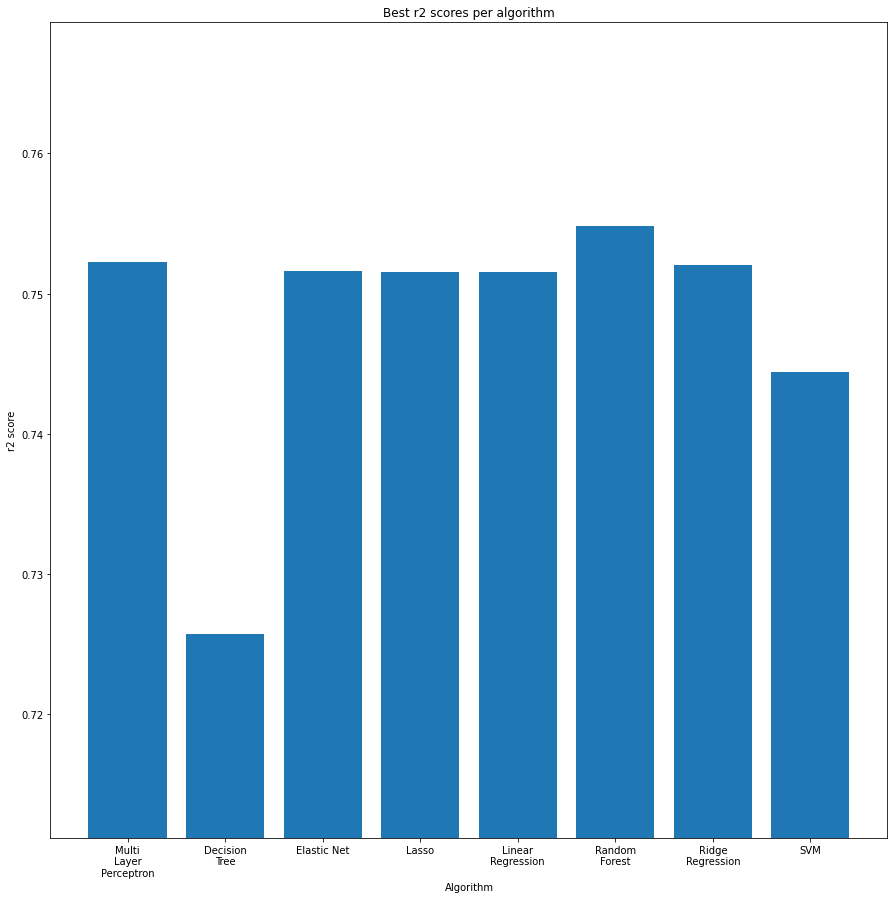

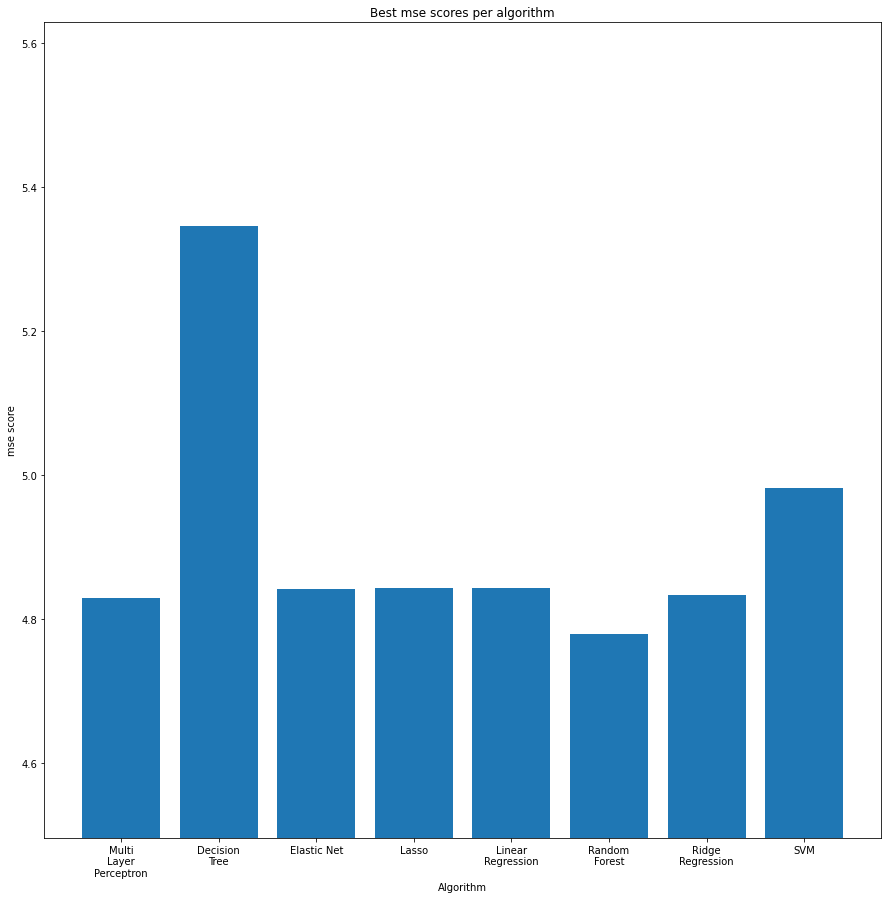

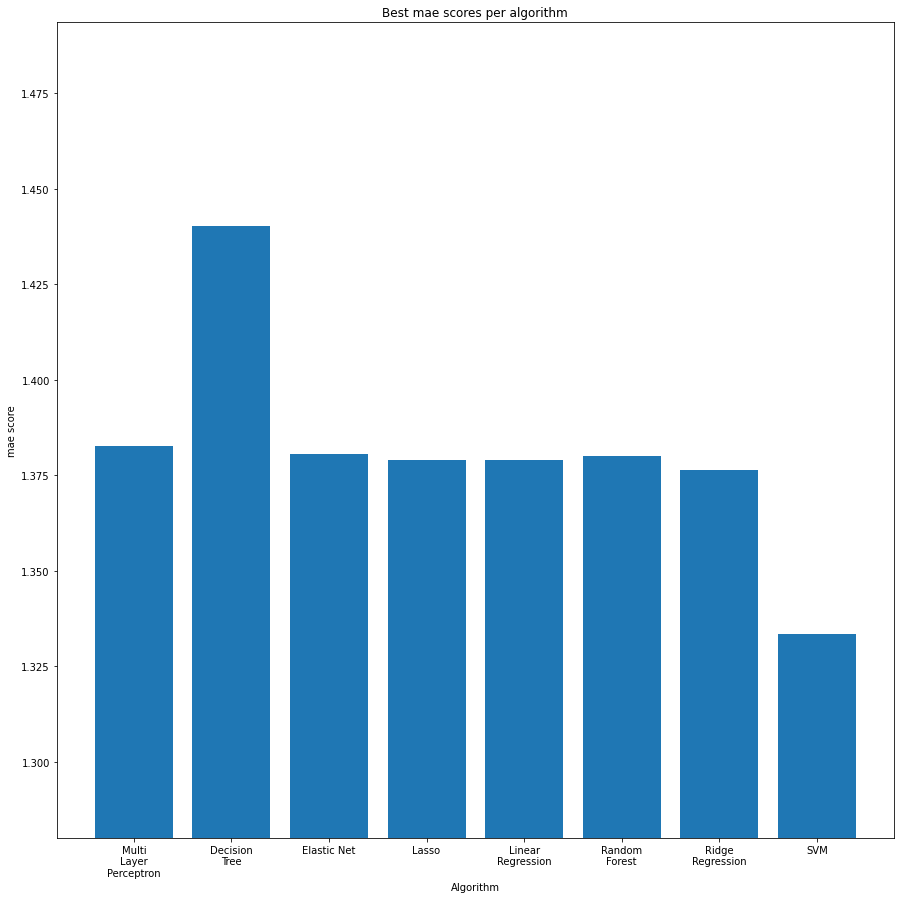

In [11]:
for metric in score_metrics:
    best_score_per_algorithm(metric)

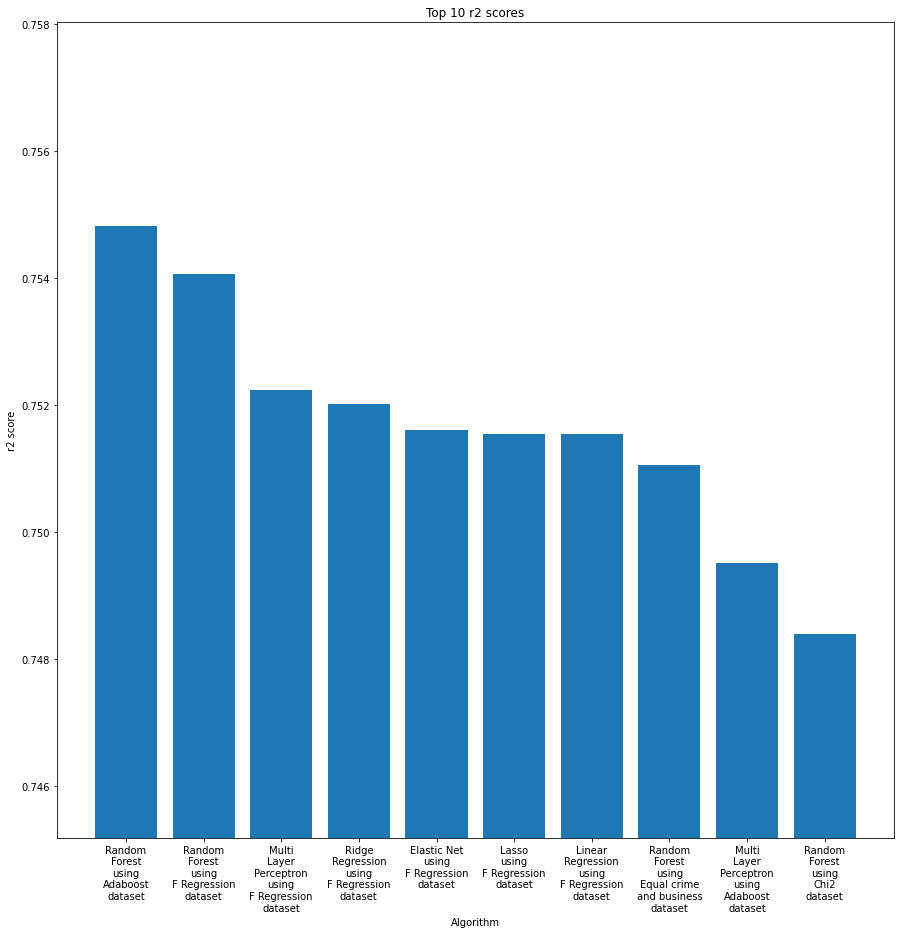

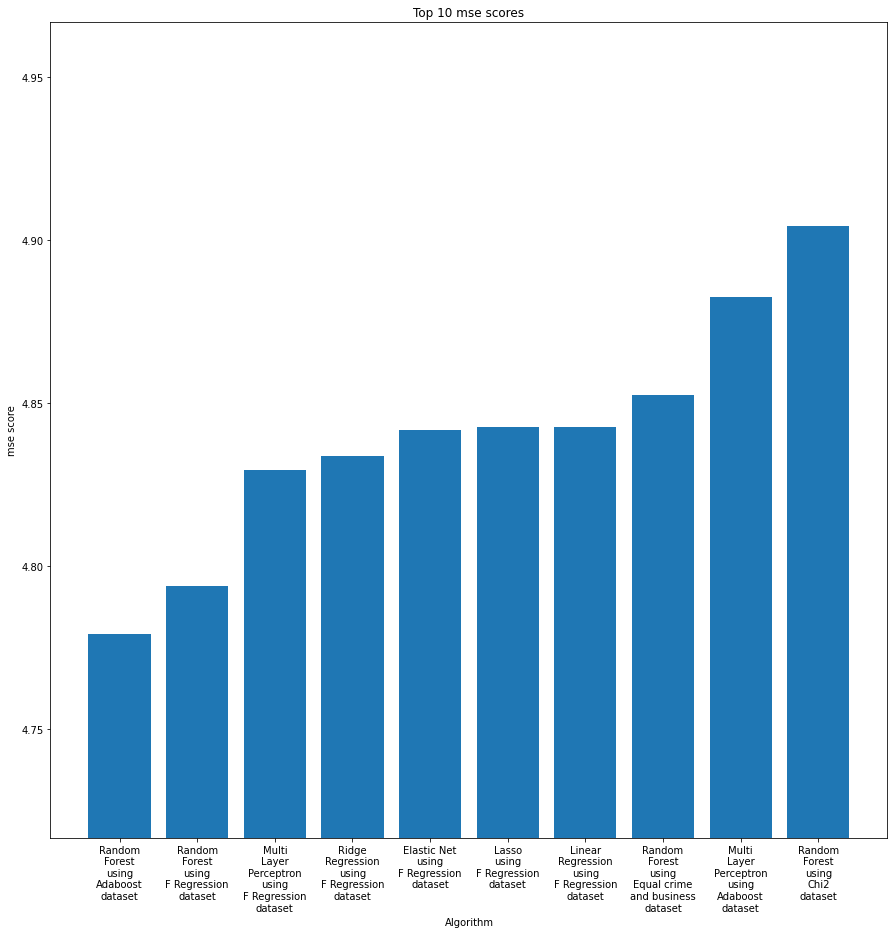

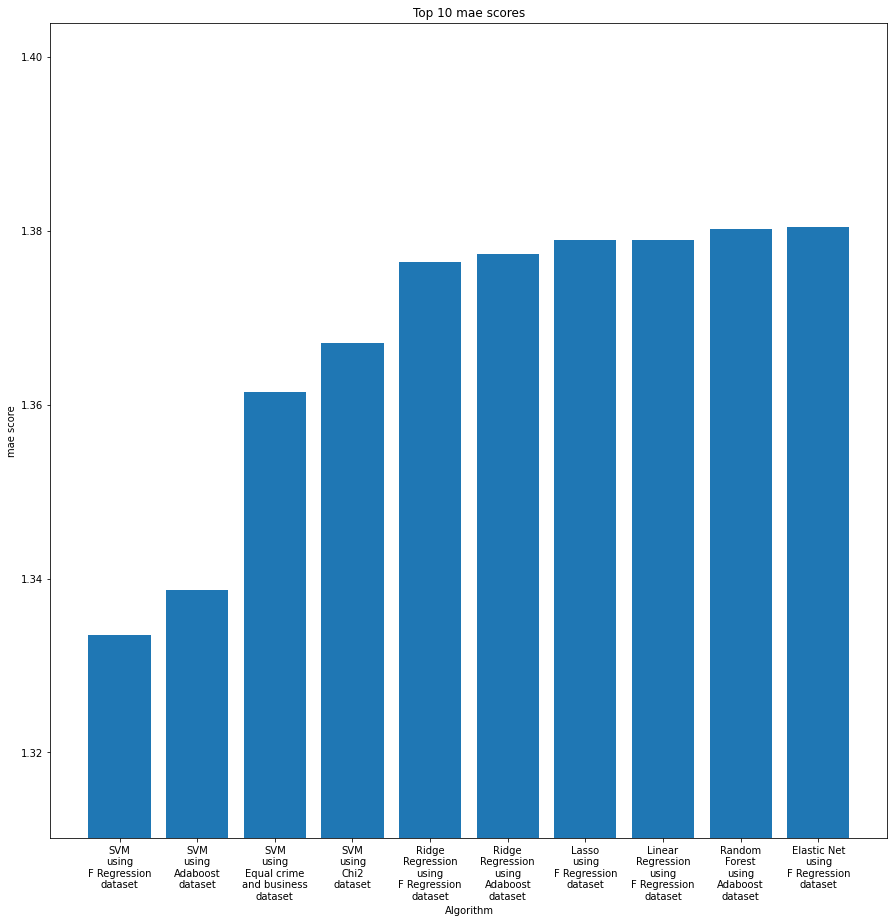

In [12]:
for metric in score_metrics:
    top_x = 10
    best_x_scores(metric,top_x)

In [13]:
# tabulate all results for comparison
def tabulate_all_results(all_results):
    new_line_labels = get_labels()
    labels = []
    for i in range(0,len(new_line_labels)):
        labels.append(new_line_labels[i].replace('\n',' '))
    table = pd.DataFrame()
    table['Machine Learning Method'] = labels
    table['R2 Score'] = all_results['r2']
    table['Mean Squared Error'] = all_results['mse']
    table['Mean Absolute Error'] = all_results['mae']
    table.style.bar(subset=['R2 Score', 'Mean Squared Error', 'Mean Absolute Error'], color='#d65f5f')
    return table

In [14]:
results = tabulate_all_results(all_results)
bar_results = results.style.bar(subset=['R2 Score', 'Mean Squared Error', 'Mean Absolute Error'],color='#2578B2')

In [15]:
bar_results

,Machine Learning Method,R2 Score,Mean Squared Error,Mean Absolute Error
0,Multi Layer Perceptron using F Regression dataset,0.752235,4.829493,1.382676
1,Multi Layer Perceptron using Chi2 dataset,0.741387,5.040947,1.407264
2,Multi Layer Perceptron using Adaboost dataset,0.749509,4.882633,1.403573
3,Multi Layer Perceptron using Equal crime and business dataset,0.743112,5.007316,1.410024
4,Multi Layer Perceptron using All Business dataset,0.542835,8.911176,1.732555
5,Decision Tree using F Regression dataset,0.721892,5.420944,1.453793
6,Decision Tree using Chi2 dataset,0.711246,5.628467,1.541826
7,Decision Tree using Adaboost dataset,0.725741,5.345919,1.440259
8,Decision Tree using Equal crime and business dataset,0.721356,5.431389,1.455141
9,Decision Tree using All Business dataset,0.521777,9.321645,1.758225


<h3> Testing begins here <h4>

<h4> Test get_lists() <h4>

In [16]:
y_test_df = pd.read_csv('y_test_tuning_tests.csv')
y_test = y_test_df['Todays Reports']
x_data_name = "x_test_tuning_tests_f_regression"
x_data_extension = ".csv"
model_path = "CrimeGUI/Models/"
algorithms = ['tuning_template_test_model_arbitrary_name']
sel_methods = ['']
expected_scores_length = 1
expected_mse = 0
expected_mae = 0
expected_r2 = 1

In [17]:
def test_get_lists():
    expected_algorithms = ['multi_layer_perceptron',
                           'decision_tree',
                           'elastic_net', 
                           'lasso',
                           'linear_regression',
                           'random_forest',
                           'ridge_regression',
                           'svm']
    expected_algorithm_display_names = ['Multi\nLayer\nPerceptron',
                                        'Decision\nTree', 
                                        'Elastic Net',  
                                        'Lasso',
                                        'Linear\nRegression',
                                        'Random\nForest',
                                        'Ridge\nRegression',
                                        'SVM']
    expected_feature_select_display_names = ['F Regression',
                               'Chi2',
                               'Adaboost',
                               'Equal crime\nand business',
                               'All Business']
    expected_highest_is_best = {"r2":True,
                  "mse":False,
                  "mae":False}
    expected_score_metrics = ["r2","mse","mae"]
    algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
    assert expected_algorithms == algorithms, "Algorithms not as expected"
    assert expected_algorithm_display_names == algorithm_display_names, "Algorithms not as expected"
    assert expected_feature_select_display_names == feature_select_display_names, "Algorithms not as expected"
    assert expected_highest_is_best == highest_is_best, "Algorithms not as expected"
    assert expected_score_metrics == score_metrics, "Algorithms not as expected"
    print("All tests completed successfully")

In [18]:
test_get_lists()

All tests completed successfully


<h4> Test get_algorithm_results <h4>

In [19]:
def test_get_algorithm_results(algorithm):
    mse_scores, mae_scores, r2_scores = get_algorithm_results(algorithm)
    assert len(mse_scores) == expected_scores_length, "Length of MSE scores not as expected."
    assert len(mae_scores) == expected_scores_length, "Length of MAE scores not as expected."
    assert len(r2_scores) == expected_scores_length, "Length of R2 scores not as expected."
    assert mse_scores[0] == expected_mse, "MSE scores not as expected."
    assert mae_scores[0] == expected_mae, "MAE scores not as expected."
    assert r2_scores[0] == expected_r2, "R2 scores not as expected."
    print("Tests completed successfully")

In [20]:
test_get_algorithm_results(algorithms[0])

Tests completed successfully


<h4> Test best_score_per_algorithm() <h4>

In [21]:
def test_best_score_per_algorithm(bar, expected_heights, x_label, y_label, expected_y, x_ticks, expected_title, title):
    assert title.get_text() == expected_title, "Title not as expected."
    rectangles = bar.get_children()
    for i in range(len(rectangles)):
        assert rectangles[i].get_height() == expected_heights[i],"Height of a rectangle not as expected."
    assert x_label.get_text() == "Algorithm", "x label not as expected."
    assert y_label.get_text() == expected_y, "y label not as expected."
    sub_headings = x_ticks[1]
    assert sub_headings, "Sub-headings not as expected"
    for i in range(0,len(sub_headings)):
        assert sub_headings[i].get_text() == algorithm_display_names[i], "Sub-headings not as expected"
    print("All bar chart tests completed successfully.")

All bar chart tests completed successfully.


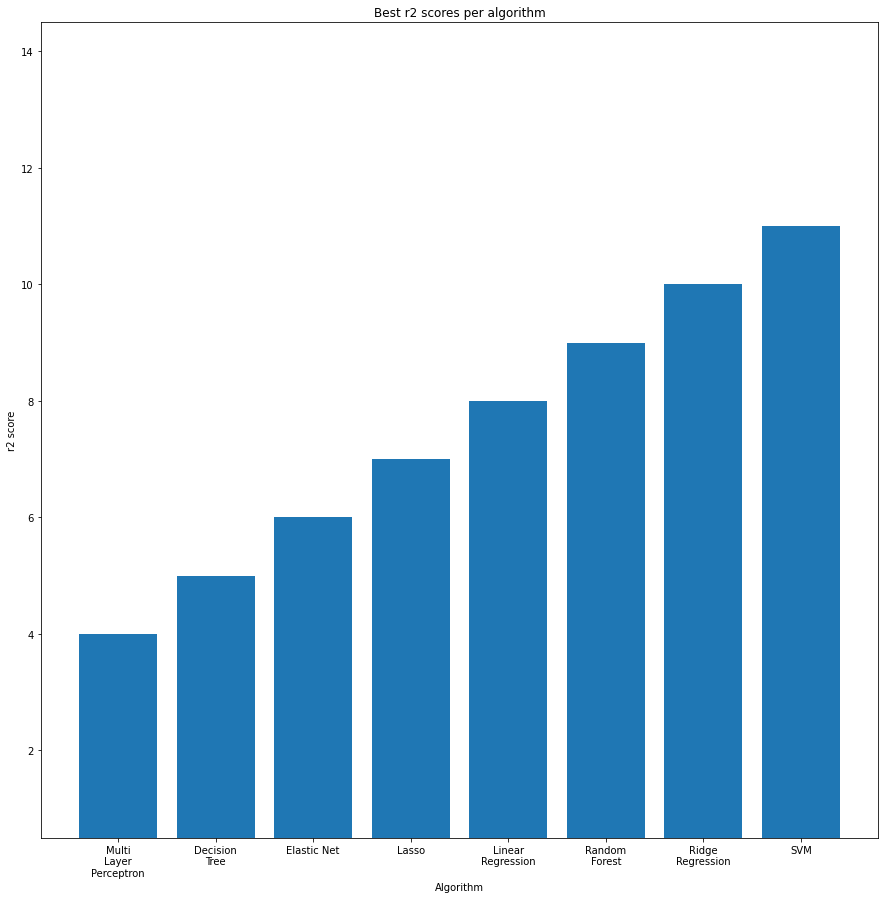

In [22]:
results_by_algorithm = {'multi_layer_perceptron':{'mse': [1.1, 2.0, 3.0, 4.0, 5.0], 
                                          'mae': [2.1, 3.0, 4.0, 5.0, 6.0], 
                                          'r2': [2.0, 3.0, 4.0, 0.0, 1.0]},
                        'decision_tree': {'mse': [1.0, 2.0, 3.0, 4.0, 5.0], 
                                          'mae': [2.0, 3.0, 4.0, 5.0, 6.0], 
                                          'r2': [3.0, 4.0, 5.0, 1.0, 2.0]}, 
                        'elastic_net': {'mse': [4.0, 5.0, 0.9, 2.0, 3.0], 
                                        'mae': [5.0, 1.9, 2.0, 3.0, 4.0], 
                                        'r2': [1.0, 2.0, 3.0, 4.0, 6.0]}, 
                        'lasso': {'mse': [2.0, 3.0, 4.0, 5.0, 0.8], 
                                  'mae': [3.0, 4.0, 5.0, 1.8, 2.0], 
                                  'r2': [4.0, 7.0, 1.0, 2.0, 3.0]}, 
                        'linear_regression': {'mse': [5.0, 0.7, 2.0, 3.0, 4.0], 
                                              'mae': [1.7, 2.0, 3.0, 4.0, 5.0], 
                                              'r2': [2.0, 3.0, 4.0, 8.0, 1.0]}, 
                        'random_forest': {'mse': [3.0, 4.0, 5.0, 0.6, 2.0], 
                                          'mae': [4.0, 5.0, 1.6, 2.0, 3.0], 
                                          'r2': [9.0, 1.0, 2.0, 3.0, 4.0]}, 
                        'ridge_regression': {'mse': [0.5, 2.0, 3.0, 4.0, 5.0],
                                             'mae': [2.0, 3.0, 4.0, 5.0, 1.5],
                                             'r2': [3.0, 4.0, 10.0, 1.0, 2.0]}, 
                        'svm': {'mse': [4.0, 5.0, 0.4, 2.0, 3.0], 
                                'mae': [5.0, 1.4, 2.0, 3.0, 4.0], 
                                'r2': [1.0, 2.0, 3.0, 4.0, 11.0]}}
expected_r2_rectangle_heights = [4,5,6,7,8,9,10,11]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'r2 score'
expected_title = "Best r2 scores per algorithm"
r2_bar, ticks, title, x_label, y_label = best_score_per_algorithm('r2')
test_best_score_per_algorithm(r2_bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_title, title)

All bar chart tests completed successfully.


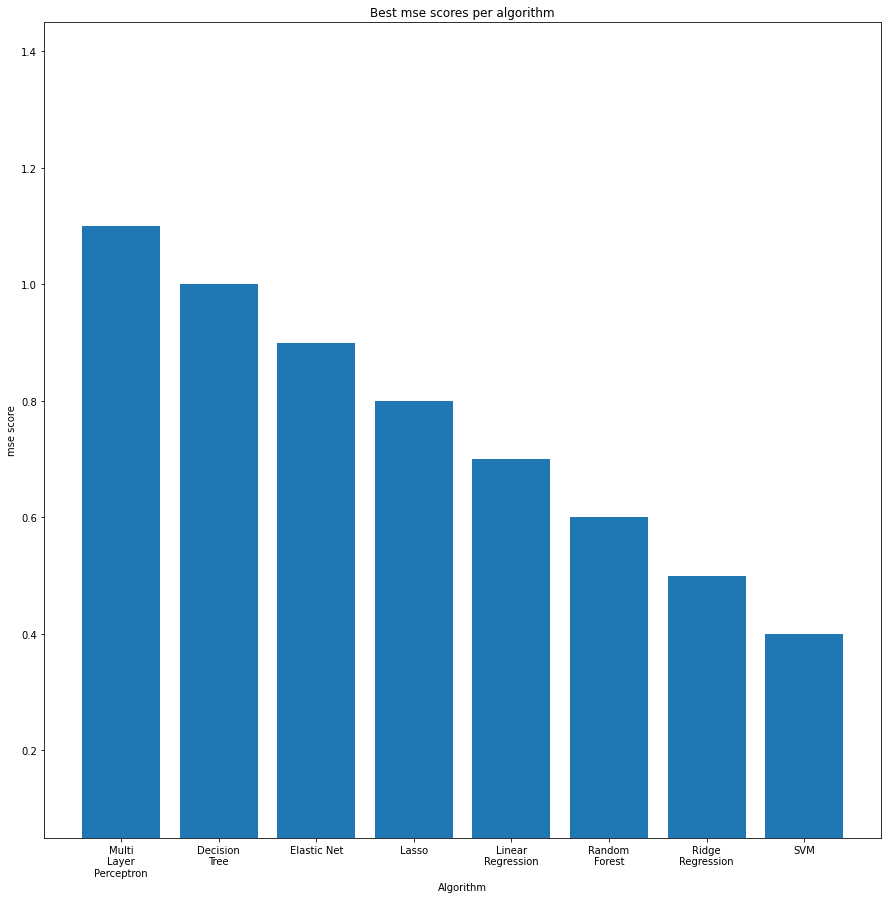

In [23]:
expected_mse_rectangle_heights = [1.1,1,0.9,0.8,0.7,0.6,0.5,0.4]
expected_y = 'mse score'
expected_title = "Best mse scores per algorithm"
mse_bar, ticks, title, x_label, y_label = best_score_per_algorithm('mse')
test_best_score_per_algorithm(mse_bar, expected_mse_rectangle_heights, x_label, y_label, expected_y, ticks, expected_title, title)

All bar chart tests completed successfully.


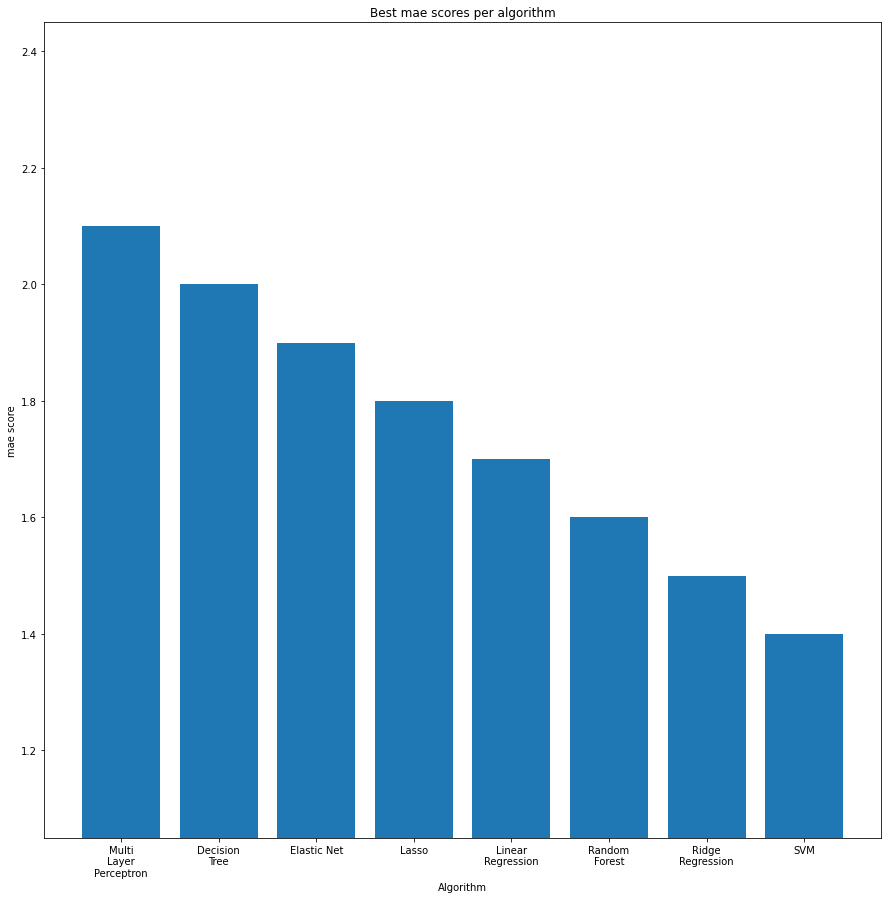

In [24]:
expected_mae_rectangle_heights = [2.1,2,1.9,1.8,1.7,1.6,1.5,1.4]
expected_y = 'mae score'
expected_title = "Best mae scores per algorithm"
mae_bar, ticks, title, x_label, y_label = best_score_per_algorithm('mae')
test_best_score_per_algorithm(mae_bar, expected_mae_rectangle_heights, x_label, y_label, expected_y, ticks, expected_title, title)

<h4> Test get_labels() <h4>

In [25]:
def test_get_labels():
    expected_labels = ['Multi\nLayer\nPerceptron\nusing\nF Regression\ndataset', 
                       'Multi\nLayer\nPerceptron\nusing\nChi2\ndataset', 
                       'Multi\nLayer\nPerceptron\nusing\nAdaboost\ndataset', 
                       'Multi\nLayer\nPerceptron\nusing\nEqual crime\nand business\ndataset',
                       'Multi\nLayer\nPerceptron\nusing\nAll Business\ndataset',
                       'Decision\nTree\nusing\nF Regression\ndataset', 
                       'Decision\nTree\nusing\nChi2\ndataset', 
                       'Decision\nTree\nusing\nAdaboost\ndataset', 
                       'Decision\nTree\nusing\nEqual crime\nand business\ndataset',
                       'Decision\nTree\nusing\nAll Business\ndataset', 
                       'Elastic Net\nusing\nF Regression\ndataset', 
                       'Elastic Net\nusing\nChi2\ndataset', 
                       'Elastic Net\nusing\nAdaboost\ndataset', 
                       'Elastic Net\nusing\nEqual crime\nand business\ndataset', 
                       'Elastic Net\nusing\nAll Business\ndataset', 
                       'Lasso\nusing\nF Regression\ndataset', 
                       'Lasso\nusing\nChi2\ndataset', 
                       'Lasso\nusing\nAdaboost\ndataset', 
                       'Lasso\nusing\nEqual crime\nand business\ndataset', 
                       'Lasso\nusing\nAll Business\ndataset', 
                       'Linear\nRegression\nusing\nF Regression\ndataset', 
                       'Linear\nRegression\nusing\nChi2\ndataset', 
                       'Linear\nRegression\nusing\nAdaboost\ndataset', 
                       'Linear\nRegression\nusing\nEqual crime\nand business\ndataset', 
                       'Linear\nRegression\nusing\nAll Business\ndataset', 
                       'Random\nForest\nusing\nF Regression\ndataset', 
                       'Random\nForest\nusing\nChi2\ndataset', 
                       'Random\nForest\nusing\nAdaboost\ndataset', 
                       'Random\nForest\nusing\nEqual crime\nand business\ndataset', 
                       'Random\nForest\nusing\nAll Business\ndataset', 
                       'Ridge\nRegression\nusing\nF Regression\ndataset', 
                       'Ridge\nRegression\nusing\nChi2\ndataset', 
                       'Ridge\nRegression\nusing\nAdaboost\ndataset', 
                       'Ridge\nRegression\nusing\nEqual crime\nand business\ndataset', 
                       'Ridge\nRegression\nusing\nAll Business\ndataset', 
                       'SVM\nusing\nF Regression\ndataset', 
                       'SVM\nusing\nChi2\ndataset', 
                       'SVM\nusing\nAdaboost\ndataset', 
                       'SVM\nusing\nEqual crime\nand business\ndataset', 
                       'SVM\nusing\nAll Business\ndataset']
    actual_labels = get_labels()
    assert expected_labels == actual_labels, "Labels not as expected."
    print("All tests completed successfully")

In [26]:
file = open("Selection Methods","rb")
sel_methods = np.load(file)
test_get_labels()

All tests completed successfully


<h4> Test validate_x() <h4>

In [27]:
def test_validate_x(num_scores, x, expected_x):
    x = validate_x(num_scores, x)
    assert x == expected_x, "x not as expected; x is " + str(x) + ", but expected " + str(expected_x) + ". i: " + str(i)

In [28]:
num_scores = [-1,-1,-1,-1,-1,-1,-1, 
              0,0,0,0,0,0,0,        
              1,1,1,1,1,1,1,        
              2,2,2,2,2,2,2,        
              14,14,14,14,14,14,14, 
              15,15,15,15,15,15,15,
              16,16,16,16,16,16,16]
x = [-1,0,1,2,14,15,16, 
     -1,0,1,2,14,15,16, 
     -1,0,1,2,14,15,16, 
     -1,0,1,2,14,15,16, 
     -1,0,1,2,14,15,16,  
     -1,0,1,2,14,15,16, 
     -1,0,1,2,14,15,16,] 
expected = [0,0,0,0,0,0,0,
           0,0,0,0,0,0,0,
           1,1,1,1,1,1,1,
           2,2,1,2,2,2,2,
           14,14,1,2,14,14,14,
           15,15,1,2,14,15,15,
           15,15,1,2,14,15,16]
for i in range(0, len(num_scores)):
    test_validate_x(num_scores[i],x[i],expected[i])
print("All tests completed successfully.")

All tests completed successfully.


In [29]:
all_results = {'mse': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
                       38,39,40,1],
               'mae': [15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1,2,3,4,5,6,7,8,9,10,
                       11,12,13,14],
               'r2': [25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                      21,22,23,24]}

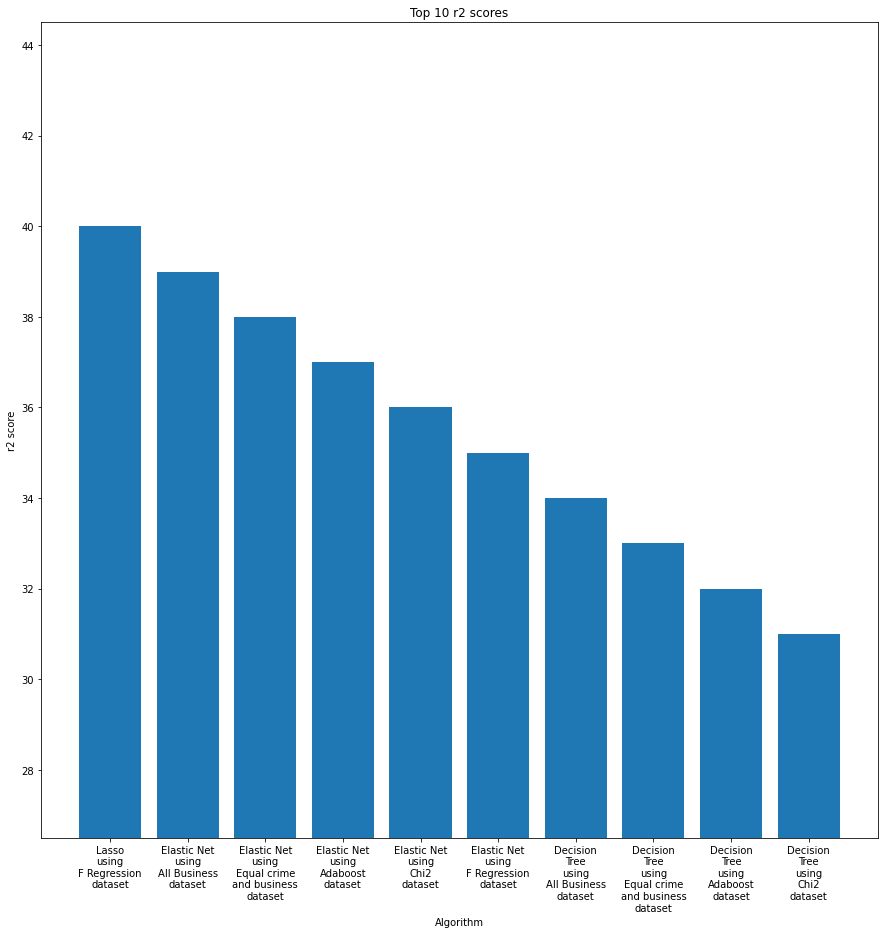

In [30]:
r2_bar, ticks, title, x_label, y_label = best_x_scores('r2',10)

<h4> Test best_x_scores() <h4>

In [31]:
def test_best_x_scores(bar, expected_heights, x_label, y_label, expected_y, x_ticks, expected_ticks, expected_title, 
                       title, expected_x):
    assert title.get_text() == expected_title, "Title not as expected."
    rectangles = bar.get_children()
    for i in range(len(rectangles)):
        assert rectangles[i].get_height() == expected_heights[i],"Height of a rectangle not as expected."
    assert x_label.get_text() == "Algorithm", "x label not as expected."
    assert y_label.get_text() == expected_y, "y label not as expected."
    sub_headings = x_ticks[1]
    assert sub_headings, "Sub-headings not as expected"
    assert len(sub_headings) == expected_x and len(rectangles) == expected_x, "Number of columns not as expected."
    for i in range(0,len(sub_headings)):
        assert sub_headings[i].get_text() == expected_ticks[i], "Sub-headings not as expected"
    print("All bar chart tests completed successfully.")

All bar chart tests completed successfully.


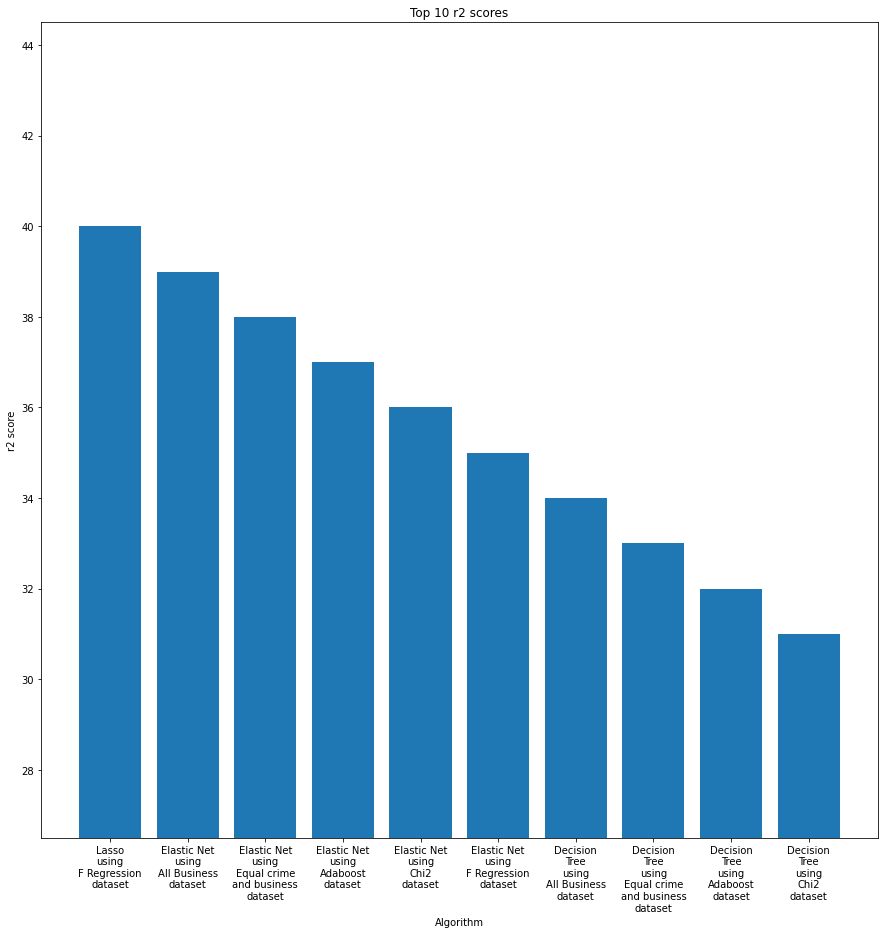

In [32]:
expected_r2_rectangle_heights = [40,39,38,37,36,35,34,33,32,31]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'r2 score'
expected_x = 10
expected_title = "Top 10 r2 scores"
expected_ticks = ['Lasso\nusing\nF Regression\ndataset','Elastic Net\nusing\nAll Business\ndataset',
                  'Elastic Net\nusing\nEqual crime\nand business\ndataset','Elastic Net\nusing\nAdaboost\ndataset',
                  'Elastic Net\nusing\nChi2\ndataset','Elastic Net\nusing\nF Regression\ndataset',
                  'Decision\nTree\nusing\nAll Business\ndataset','Decision\nTree\nusing\nEqual crime\nand business\ndataset',
                  'Decision\nTree\nusing\nAdaboost\ndataset','Decision\nTree\nusing\nChi2\ndataset']
r2_bar, ticks, title, x_label, y_label = best_x_scores('r2',10)
test_best_x_scores(r2_bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

All bar chart tests completed successfully.


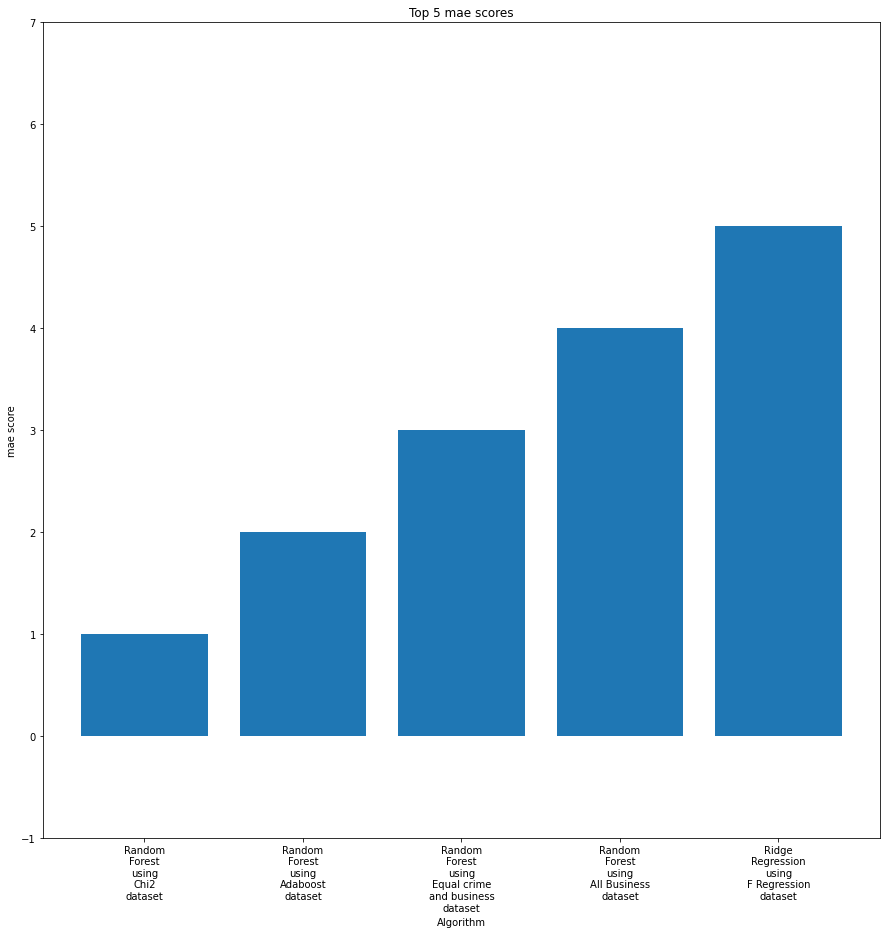

In [33]:
expected_r2_rectangle_heights = [1,2,3,4,5]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'mae score'
expected_x = 5
expected_title = "Top 5 mae scores"
expected_ticks = ['Random\nForest\nusing\nChi2\ndataset','Random\nForest\nusing\nAdaboost\ndataset',
                  'Random\nForest\nusing\nEqual crime\nand business\ndataset','Random\nForest\nusing\nAll Business\ndataset',
                  'Ridge\nRegression\nusing\nF Regression\ndataset']
bar, ticks, title, x_label, y_label = best_x_scores('mae',5)
test_best_x_scores(bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

All bar chart tests completed successfully.


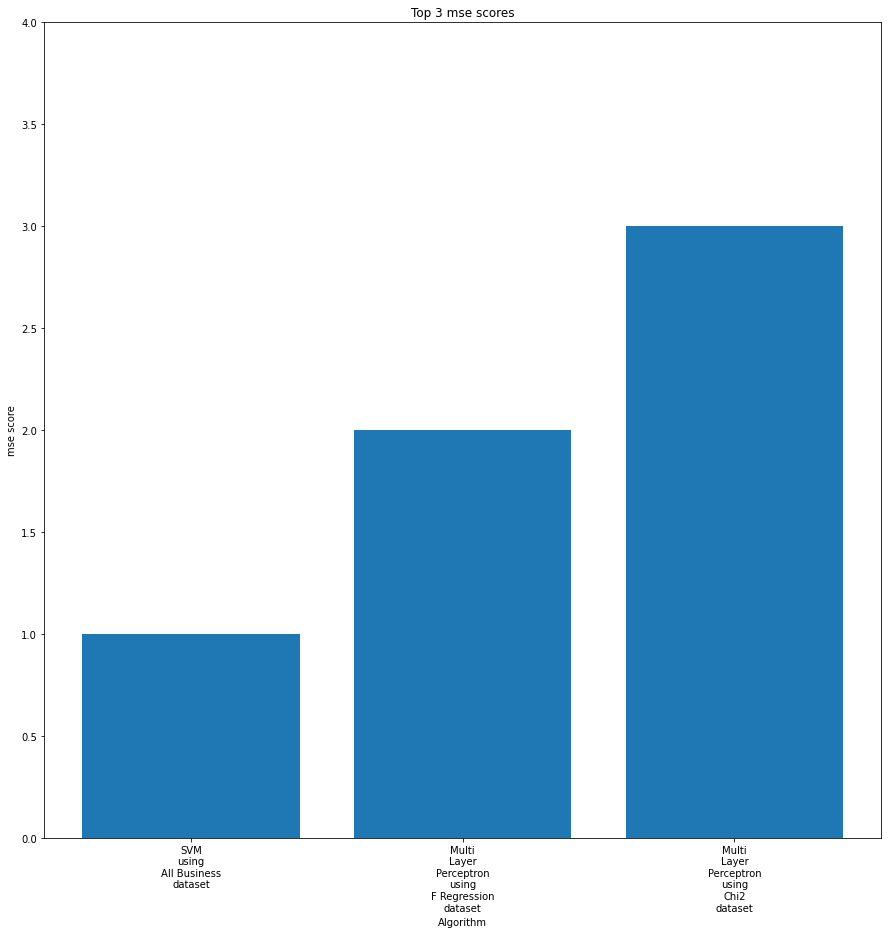

In [34]:
expected_r2_rectangle_heights = [1,2,3]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'mse score'
expected_x = 3
expected_title = "Top 3 mse scores"
expected_ticks = ['SVM\nusing\nAll Business\ndataset','Multi\nLayer\nPerceptron\nusing\nF Regression\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nChi2\ndataset']
bar, ticks, title, x_label, y_label = best_x_scores('mse',3)
test_best_x_scores(bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

All bar chart tests completed successfully.


<ipython-input-10-ed7a05cfc17f>:31: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  plt.ylim(bottom = min_y, top = max_y)


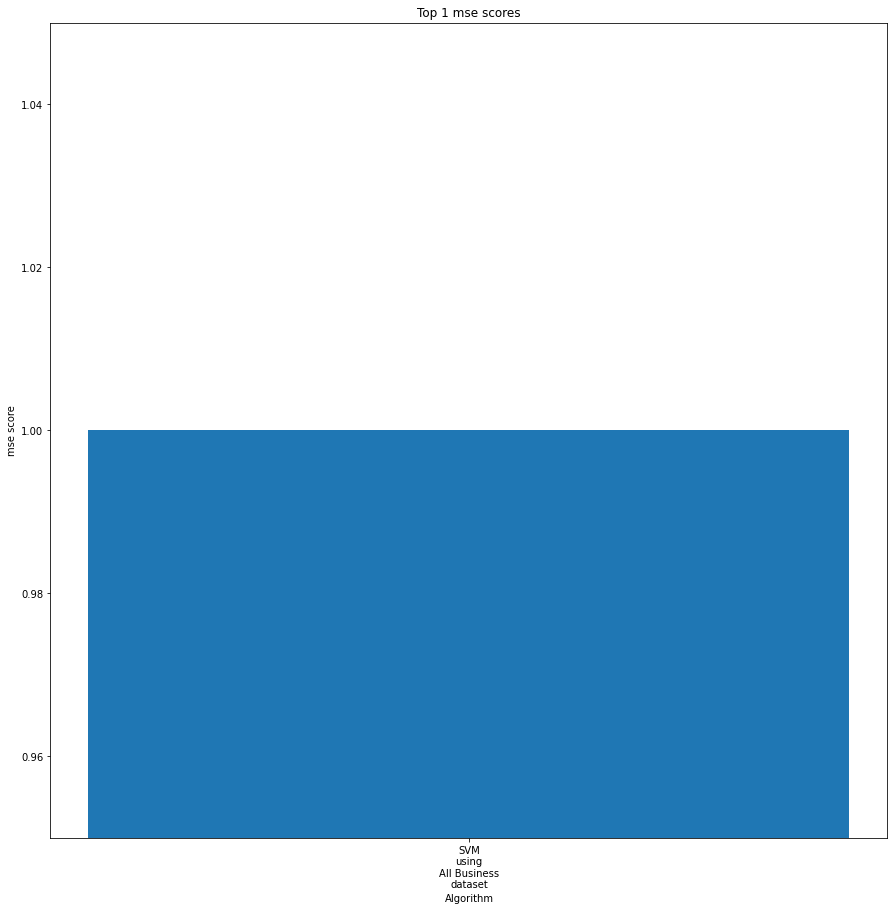

In [35]:
expected_r2_rectangle_heights = [1]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'mse score'
expected_x = 1
expected_title = "Top 1 mse scores"
expected_ticks = ['SVM\nusing\nAll Business\ndataset', 'Decision\nTree\nusing\nF Regression\ndataset',
                 'Decision\nTree\nusing\nChi2\ndataset']
bar, ticks, title, x_label, y_label = best_x_scores('mse',1)
test_best_x_scores(bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

All bar chart tests completed successfully.


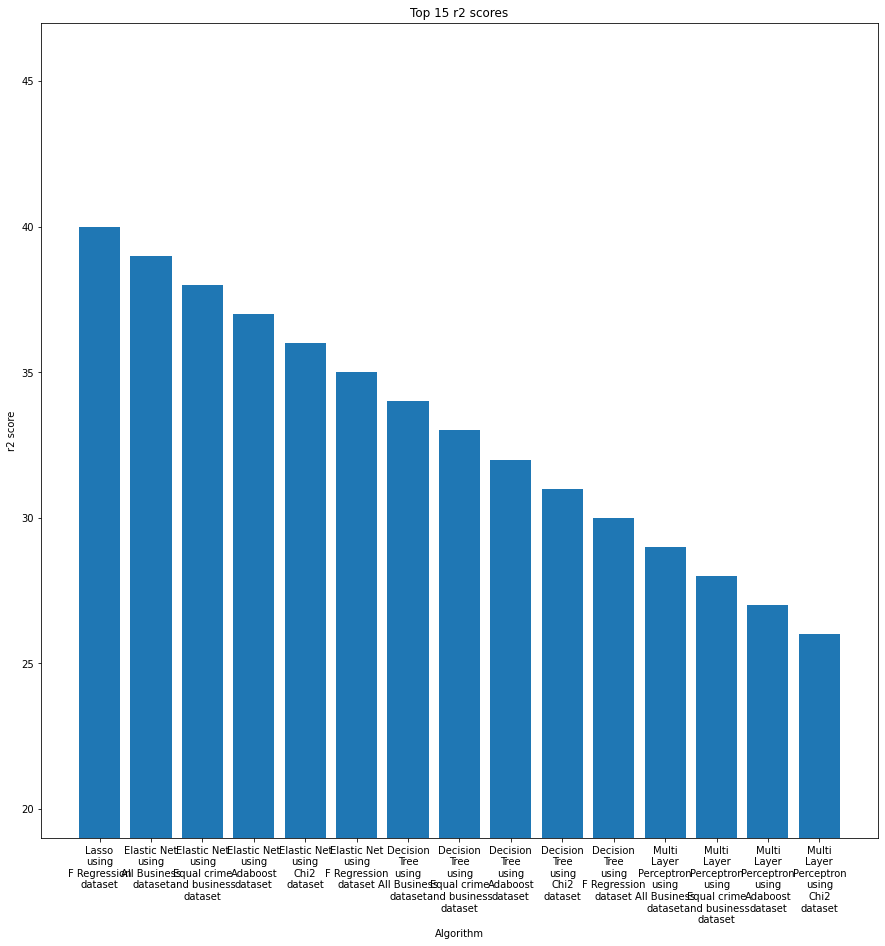

In [36]:
expected_r2_rectangle_heights = [40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'r2 score'
expected_x = 15
expected_title = "Top 15 r2 scores"
expected_ticks = ['Lasso\nusing\nF Regression\ndataset', 'Elastic Net\nusing\nAll Business\ndataset', 
                  'Elastic Net\nusing\nEqual crime\nand business\ndataset', 'Elastic Net\nusing\nAdaboost\ndataset', 
                  'Elastic Net\nusing\nChi2\ndataset','Elastic Net\nusing\nF Regression\ndataset',
                  'Decision\nTree\nusing\nAll Business\ndataset', 'Decision\nTree\nusing\nEqual crime\nand business\ndataset',
                  'Decision\nTree\nusing\nAdaboost\ndataset', 'Decision\nTree\nusing\nChi2\ndataset',
                  'Decision\nTree\nusing\nF Regression\ndataset', 'Multi\nLayer\nPerceptron\nusing\nAll Business\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nEqual crime\nand business\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nAdaboost\ndataset','Multi\nLayer\nPerceptron\nusing\nChi2\ndataset']
bar, ticks, title, x_label, y_label = best_x_scores('r2',0)
test_best_x_scores(bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

All bar chart tests completed successfully.


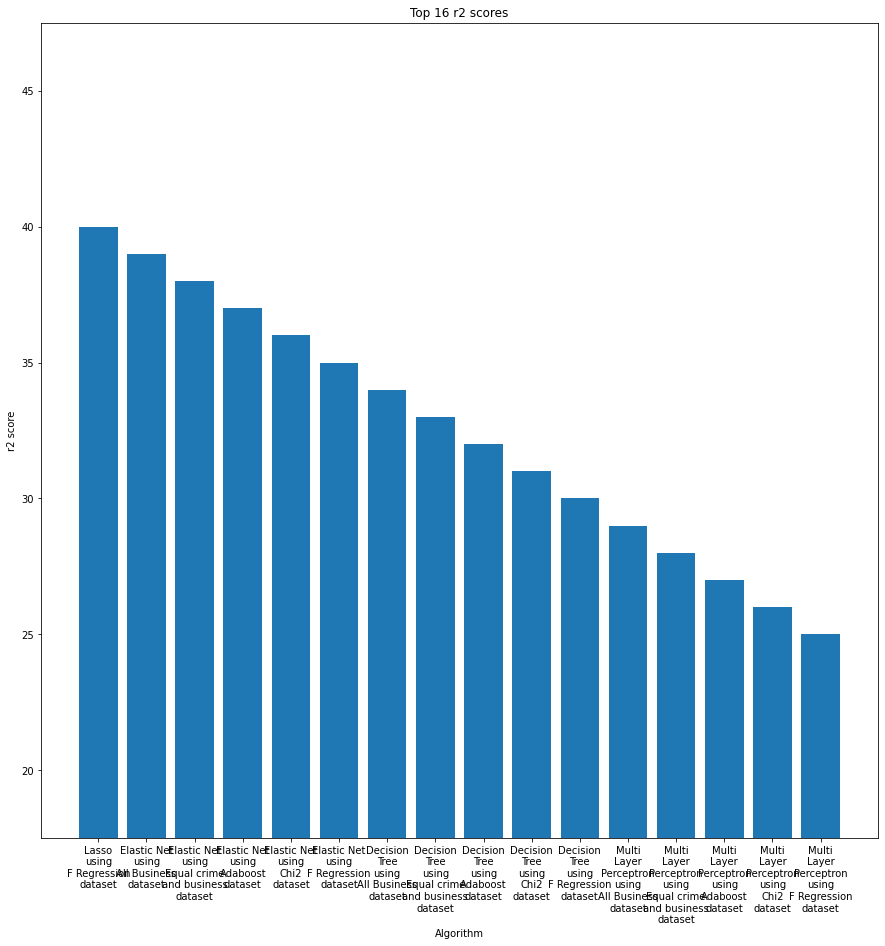

In [37]:
expected_r2_rectangle_heights = [40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'r2 score'
expected_x = 16
expected_title = "Top 16 r2 scores"
expected_ticks = ['Lasso\nusing\nF Regression\ndataset', 'Elastic Net\nusing\nAll Business\ndataset', 
                  'Elastic Net\nusing\nEqual crime\nand business\ndataset', 'Elastic Net\nusing\nAdaboost\ndataset', 
                  'Elastic Net\nusing\nChi2\ndataset', 'Elastic Net\nusing\nF Regression\ndataset', 
                  'Decision\nTree\nusing\nAll Business\ndataset','Decision\nTree\nusing\nEqual crime\nand business\ndataset', 
                  'Decision\nTree\nusing\nAdaboost\ndataset', 'Decision\nTree\nusing\nChi2\ndataset',
                  'Decision\nTree\nusing\nF Regression\ndataset', 'Multi\nLayer\nPerceptron\nusing\nAll Business\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nEqual crime\nand business\ndataset', 
                  'Multi\nLayer\nPerceptron\nusing\nAdaboost\ndataset', 'Multi\nLayer\nPerceptron\nusing\nChi2\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nF Regression\ndataset']
bar, ticks, title, x_label, y_label = best_x_scores('r2',16)
test_best_x_scores(bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

In [38]:
all_results = {'mse': [2,3,4,5,6],
 'mae': [15,16,17,18,19],
 'r2': [25,26,27,28,29]}

All bar chart tests completed successfully.


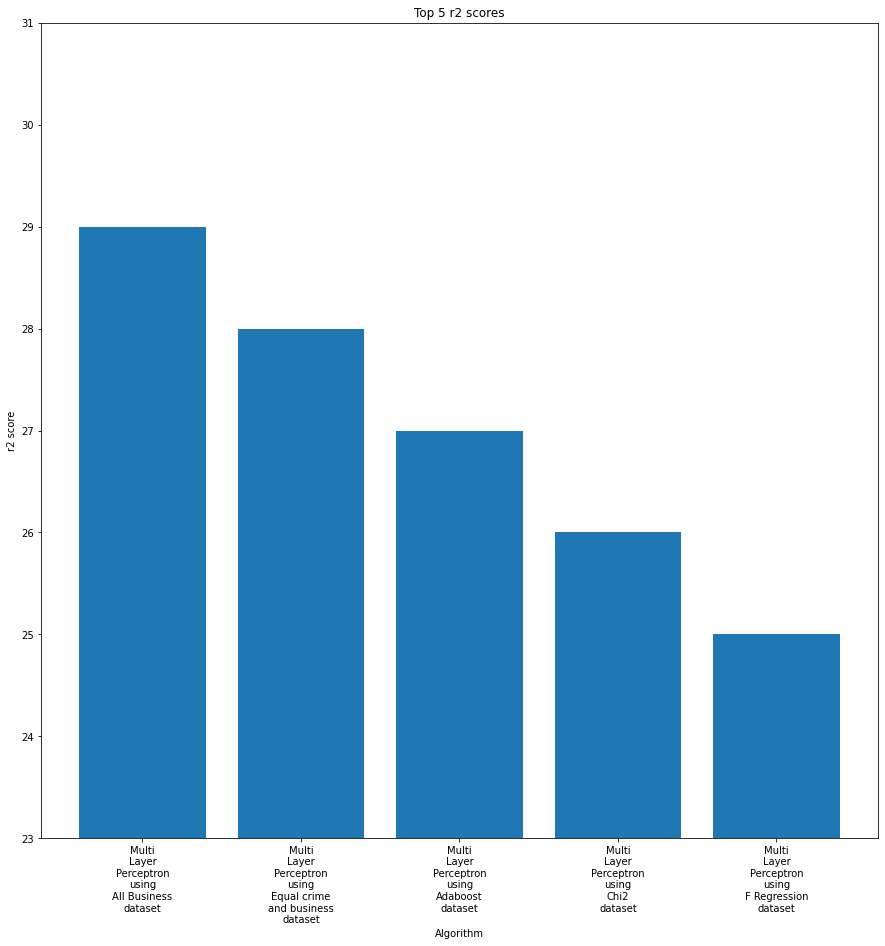

In [39]:
expected_r2_rectangle_heights = [29,28,27,26,25]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'r2 score'
expected_x = 5
expected_title = "Top 5 r2 scores"
expected_ticks = ['Multi\nLayer\nPerceptron\nusing\nAll Business\ndataset', 'Multi\nLayer\nPerceptron\nusing\nEqual crime\nand business\ndataset','Multi\nLayer\nPerceptron\nusing\nAdaboost\ndataset','Multi\nLayer\nPerceptron\nusing\nChi2\ndataset','Multi\nLayer\nPerceptron\nusing\nF Regression\ndataset']
bar, ticks, title, x_label, y_label = best_x_scores('r2',5)
test_best_x_scores(bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

All bar chart tests completed successfully.


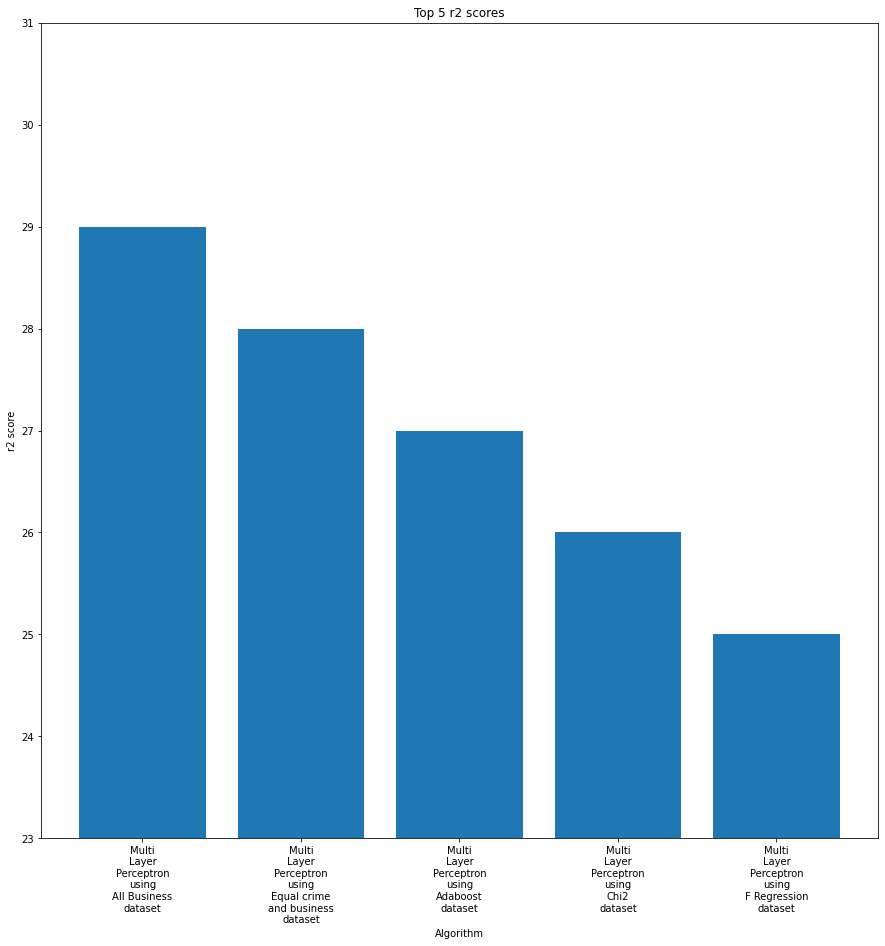

In [40]:
expected_r2_rectangle_heights = [29,28,27,26,25]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'r2 score'
expected_x = 5
expected_title = "Top 5 r2 scores"
expected_ticks = ['Multi\nLayer\nPerceptron\nusing\nAll Business\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nEqual crime\nand business\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nAdaboost\ndataset','Multi\nLayer\nPerceptron\nusing\nChi2\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nF Regression\ndataset']
bar, ticks, title, x_label, y_label = best_x_scores('r2',6)
test_best_x_scores(bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

All bar chart tests completed successfully.


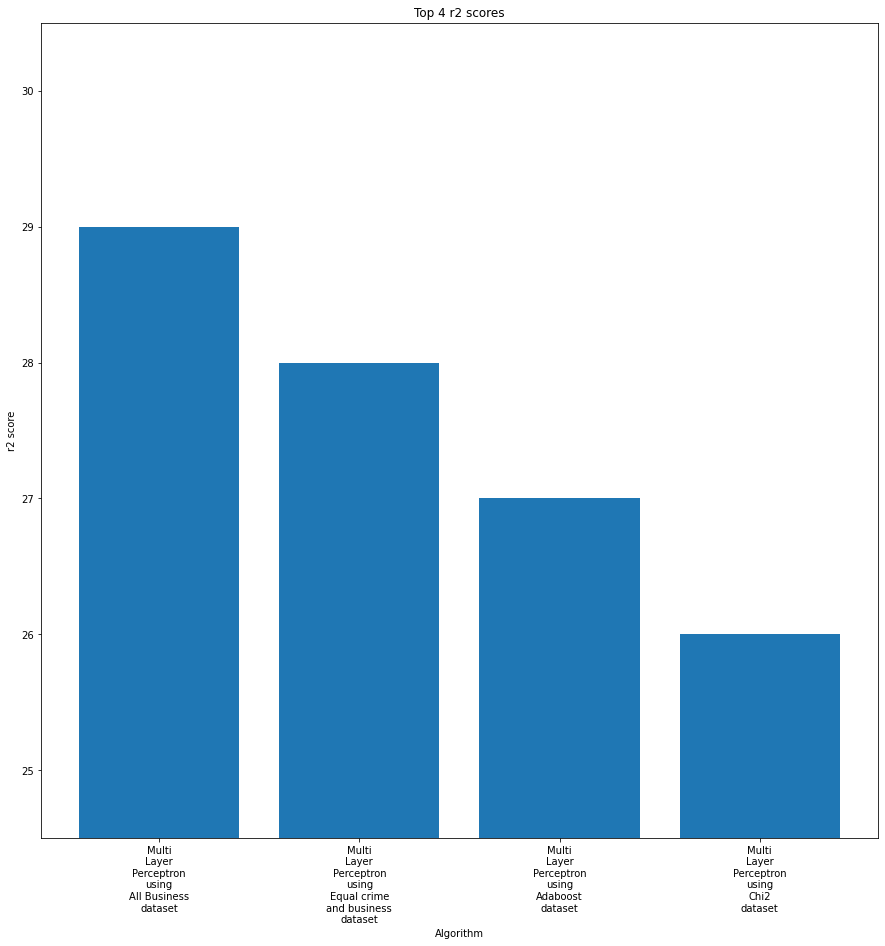

In [41]:
expected_r2_rectangle_heights = [29,28,27,26,25]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'r2 score'
expected_x = 4
expected_title = "Top 4 r2 scores"
expected_ticks = ['Multi\nLayer\nPerceptron\nusing\nAll Business\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nEqual crime\nand business\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nAdaboost\ndataset','Multi\nLayer\nPerceptron\nusing\nChi2\ndataset']
bar, ticks, title, x_label, y_label = best_x_scores('r2',4)
test_best_x_scores(bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

All bar chart tests completed successfully.


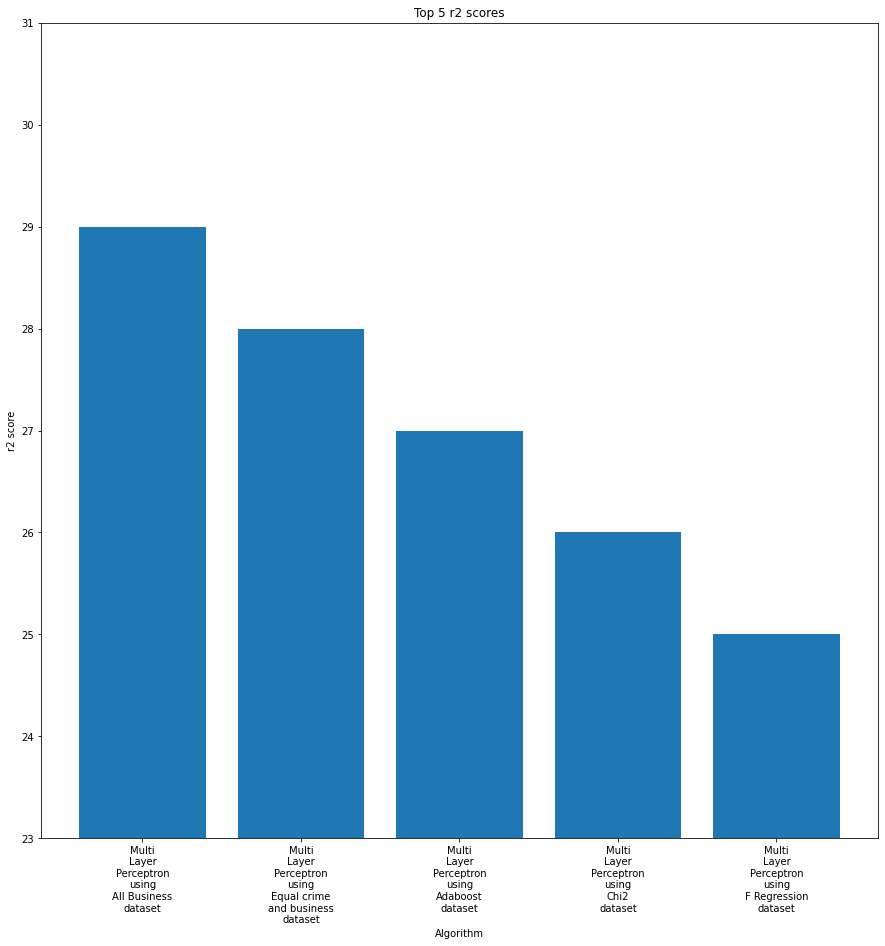

In [42]:
expected_r2_rectangle_heights = [29,28,27,26,25]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'r2 score'
expected_x = 5
expected_title = "Top 5 r2 scores"
expected_ticks = ['Multi\nLayer\nPerceptron\nusing\nAll Business\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nEqual crime\nand business\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nAdaboost\ndataset','Multi\nLayer\nPerceptron\nusing\nChi2\ndataset',
                  'Multi\nLayer\nPerceptron\nusing\nF Regression\ndataset',]
bar, ticks, title, x_label, y_label = best_x_scores('r2',0)
test_best_x_scores(bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

All bar chart tests completed successfully.


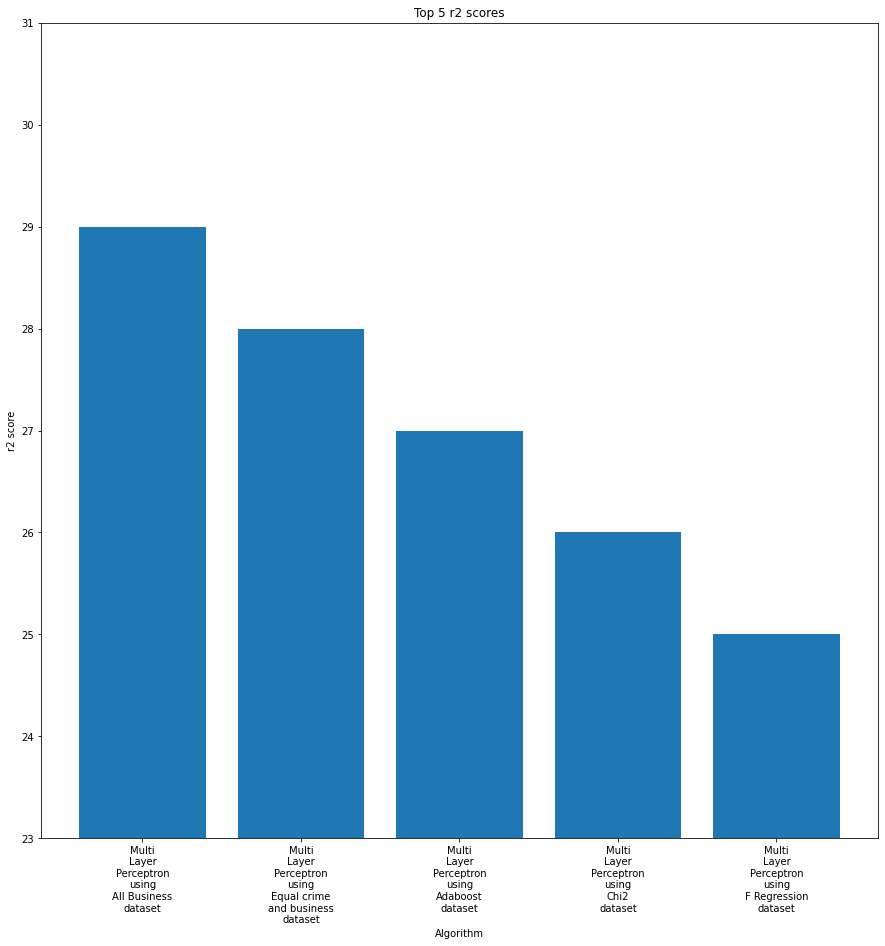

In [43]:
expected_r2_rectangle_heights = [29,28,27,26,25]
algorithms, algorithm_display_names, feature_select_display_names, highest_is_best, score_metrics = setup_lists()
expected_y = 'r2 score'
expected_x = 5
expected_title = "Top 5 r2 scores"
expected_ticks = ['Multi\nLayer\nPerceptron\nusing\nAll Business\ndataset', 'Multi\nLayer\nPerceptron\nusing\nEqual crime\nand business\ndataset','Multi\nLayer\nPerceptron\nusing\nAdaboost\ndataset','Multi\nLayer\nPerceptron\nusing\nChi2\ndataset', 'Multi\nLayer\nPerceptron\nusing\nF Regression\ndataset']
bar, ticks, title, x_label, y_label = best_x_scores('r2',-1)
test_best_x_scores(bar, expected_r2_rectangle_heights, x_label, y_label, expected_y, ticks, expected_ticks, expected_title, 
               title, expected_x)

In [44]:
all_results = {'mse': [36,37,38,39,40,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,1],
 'mae': [40,39,38,37,36,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
 'r2': [38,39,40,37,36,25,26,27,28,29,30,31,32,33,34,35,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]}

In [45]:
def test_table(table, expected_columns, expected_labels,expected_r2,expected_mae,expected_mse):
    columns = table.columns
    for col in columns:
        assert col in expected_columns, "Table columns not as expected."
    for col in expected_columns:
        assert col in columns, "Table columns not as expected."
    methods = table['Machine Learning Method']
    for i in range (0,len(methods)):
        assert methods[i] == expected_labels[i], "Method " + str(expected_labels[i]) + " expected, but got " + str (methods[i])
    r2_scores = table['R2 Score']
    for i in range (0,len(r2_scores)):
        assert r2_scores[i] == expected_r2[i], "Score " + str(expected_labels[i]) + " expected, but got " + str (methods[i])
    mae_scores = table['Mean Absolute Error']
    for i in range (0,len(mae_scores)):
        assert mae_scores[i] == expected_mae[i], "Score " + str(expected_labels[i]) + " expected, but got " + str (methods[i])
    mse_scores = table['Mean Squared Error']
    for i in range (0,len(mse_scores)):
        assert mse_scores[i] == expected_mse[i], "Score " + str(expected_labels[i]) + " expected, but got " + str (methods[i])
    print("All tests completed successfully")  

In [46]:
expected_labels = ['Multi Layer Perceptron using F Regression dataset','Multi Layer Perceptron using Chi2 dataset',
                   'Multi Layer Perceptron using Adaboost dataset',
                   'Multi Layer Perceptron using Equal crime and business dataset', 
                   'Multi Layer Perceptron using All Business dataset',
                   'Decision Tree using F Regression dataset','Decision Tree using Chi2 dataset',
                   'Decision Tree using Adaboost dataset','Decision Tree using Equal crime and business dataset',
                   'Decision Tree using All Business dataset','Elastic Net using F Regression dataset',
                   'Elastic Net using Chi2 dataset','Elastic Net using Adaboost dataset',
                   'Elastic Net using Equal crime and business dataset','Elastic Net using All Business dataset',
                   'Lasso using F Regression dataset','Lasso using Chi2 dataset','Lasso using Adaboost dataset',
                   'Lasso using Equal crime and business dataset','Lasso using All Business dataset',
                   'Linear Regression using F Regression dataset','Linear Regression using Chi2 dataset',
                   'Linear Regression using Adaboost dataset','Linear Regression using Equal crime and business dataset',
                   'Linear Regression using All Business dataset','Random Forest using F Regression dataset',
                   'Random Forest using Chi2 dataset','Random Forest using Adaboost dataset',
                   'Random Forest using Equal crime and business dataset','Random Forest using All Business dataset',
                   'Ridge Regression using F Regression dataset','Ridge Regression using Chi2 dataset',
                   'Ridge Regression using Adaboost dataset','Ridge Regression using Equal crime and business dataset',
                   'Ridge Regression using All Business dataset','SVM using F Regression dataset',
                   'SVM using Chi2 dataset','SVM using Adaboost dataset','SVM using Equal crime and business dataset',
                   'SVM using All Business dataset']
expected_columns = ["Machine Learning Method","R2 Score","Mean Squared Error","Mean Absolute Error"]
expected_r2 = all_results['r2']
expected_mae = all_results['mae']
expected_mse = all_results['mse']
table = tabulate_all_results(all_results)

In [47]:
test_table(table, expected_columns, expected_labels,expected_r2,expected_mae,expected_mse)

All tests completed successfully


<h3> All tests completed successfully <h3>